# Tracking Climate Change Opinions from Twitter Data 
### November 6, 2015


## Gilles Comeau & David Dowey

# Preliminaries

### Import statements for libraries

In [1]:
#############################
### NumPy
import numpy as np

#############################
### Pandas
import pandas as pd # pandas
from pandas import Series,  DataFrame
pd.options.display.mpl_style = 'default'

#############################
### Language
import nltk
import re
import string

#############################
### Sklearn
import sklearn
from sklearn import feature_selection, feature_extraction
from sklearn import metrics
from sklearn import cross_validation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

#############################
### Matplotlib
import matplotlib.pyplot as plt # module for plotting 
from matplotlib import interactive, font_manager
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

#############################
### other stuff
from IPython import display

%matplotlib inline  

### Configuration definitions for plotting in Matplotlib

In [43]:
######################################
######################################
# Matplotlib config code taken from CS109 2013 
######################################

dark2_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
dark2_cmap = ListedColormap(dark2_colors)
light_grey = np.array([float(248)/float(255)]*3)
shade_black = '#262626'

def set_mpl_params():
    rcParams['figure.figsize'] = (10, 6)
    rcParams['figure.dpi'] = 150
    rcParams['axes.color_cycle'] = dark2_colors
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 12
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

######################################
######################################
# Remove border function taken from CS109 2013 
######################################
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

mpl.rcdefaults()
% matplotlib inline
set_mpl_params()

In [3]:
# This is here to avoid all the Matplotlib warnings due to current bugs 
# - not a good idea to keep around
import warnings
warnings.filterwarnings('ignore')

## Load the data from the various txt files
### Separate by labels and by file for the unlabeled data

In [4]:
All_tweets = pd.DataFrame()
names = ['Positive', 'Negative', 'Cannot_Decide']
for name in names:
    file ='%s_Twitter.txt' % name
    print (file)
    #frame = pd.read_csv('Positive_Twitter.txt', header=None, sep=r"\n")
    frame = pd.read_csv(file, header=None, sep=r"\n")
    frame['Ident'] = name
    All_tweets = All_tweets.append(frame, ignore_index=True)
    
    
dates = range(1, 29)
for days in dates:
    file ='Climate_Twitter_%d.txt' % days
    frame = pd.read_csv(file, header=None, sep=r"\n")
    frame['Ident'] = 'Twitter_%d' % days
    All_tweets = All_tweets.append(frame, ignore_index=True)
    
All_tweets = All_tweets.rename(columns = {0:'Tweets'})
All_tweets = All_tweets.dropna().reset_index(drop=True)
All_tweets['Tweets'] = All_tweets['Tweets'].str.replace(r'\d+\.', '')
#All_tweets['Tweets'] = All_tweets['Tweets'].str.replace(r'(http|https):\/\/\S+', '')
All_tweets['Tweets'] = All_tweets['Tweets'].str.replace(r'(http|https):\S+', '')

Positive_Twitter.txt
Negative_Twitter.txt
Cannot_Decide_Twitter.txt


In [6]:
print (All_tweets.shape)
#All_tweets.head()

(299056, 2)


### Create a cleaned vocabulary in order to look at the data and check out stopwords / tokenization

In [7]:
from nltk.tokenize import wordpunct_tokenize, RegexpTokenizer, WhitespaceTokenizer
word_tokenizer = nltk.RegexpTokenizer(r'\w+')

In [8]:
Cleaned_tweets = All_tweets.copy(deep=True)
Cleaned_tweets.Tweets = Cleaned_tweets.Tweets.str.lower()
Cleaned_tweets.Tweets = Cleaned_tweets.Tweets.apply(word_tokenizer.tokenize)
#Cleaned_tweets.head()

### Stopwords
A corpus of stopwords for English is included in the  [NLTK](http://www.nltk.org/) resources.  [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", "in", "not", "so", "that", etc.  
The least frequent words are also extracted  - those occurring less than three times.

In [9]:
# Load English stopwords from NLTK
from nltk.corpus import stopwords
from nltk import FreqDist

In [10]:
tokens = []
[tokens.extend(words) for words in Cleaned_tweets.Tweets]
vocab = nltk.Text(tokens)

In [11]:
freq_dist = FreqDist(vocab)
rarewords = [w for w in set(vocab) if freq_dist[w] <= 2]
most_frequent_10 = [ x[0] for x in freq_dist.most_common(10)]

In [12]:
print (most_frequent_10)
print (rarewords[:20])
print(len(rarewords))

['climate', 'change', 'the', 'to', 'of', 'is', 'on', 'and', 'a', 'in']
['cavaliers', 'cti14', 'seei', 'viticulturists', '10anta', 'elong', 'visting', 'looool', 'trishhernandez', 'jedieconomist', 'operationlifeboat', '2make', 'mk4', 'sanjukkta', 'bllorenz', 'vwarheit', 'iisd_news', 'bliisssss', 'coley', 'asking4money']
66875


In [13]:
# create a master list of stopwords
all_stopwords = rarewords + most_frequent_10 + stopwords.words('english')
all_stopwords_set = set([x.lower() for x in all_stopwords])

def stopword_clean(text):
    cleaned = [x for x in text if x.lower() not in all_stopwords_set]
    return cleaned

### Stemming
For [stemming](http://en.wikipedia.org/wiki/Stemming) of words by breaking them down to their stem components.

In [14]:
# Porter stemmer
porter = nltk.PorterStemmer()
# Snowball stemmer
snowball = nltk.SnowballStemmer('english')
# Lancaster stemmer
lancaster = nltk.LancasterStemmer()

# General stemming Lambda function to stem tokens
stemmed = lambda tokens: [snowball.stem(t) for t in tokens]

In [15]:
Cleaned_tweets = Cleaned_tweets.Tweets.apply(stopword_clean)
Cleaned_tweets = Cleaned_tweets.apply(stemmed)

In [16]:
Cleaned_tweets = Cleaned_tweets[(Cleaned_tweets.str.len() != 0)].reset_index(drop=True)
#Cleaned_tweets.head(30)

## Create training and testing datasets

In [18]:
Labeled_data_pos = All_tweets[(All_tweets['Ident'] == 'Positive') ]
Labeled_data_neg = All_tweets[(All_tweets['Ident'] == 'Negative') ]
print (Labeled_data_pos.shape, Labeled_data_neg.shape)

Validation = All_tweets[All_tweets['Ident'].str.contains('Twitter_')]
print (Validation.shape)

(1049, 2) (502, 2)
(296457, 2)


In [19]:
from sklearn.cross_validation import train_test_split
Xdata_train_pos, Xdata_test_pos, Ydata_train_pos, Ydata_test_pos  =  sklearn.cross_validation.train_test_split(
    Labeled_data_pos['Tweets'], Labeled_data_pos['Ident'], train_size = 790)
Xdata_train_neg, Xdata_test_neg, Ydata_train_neg, Ydata_test_neg  =  sklearn.cross_validation.train_test_split(
    Labeled_data_neg['Tweets'], Labeled_data_neg['Ident'], train_size = 400)

In [20]:
Xdata_train = np.hstack((Xdata_train_pos, Xdata_train_neg))
print (len(Xdata_train))
Xdata_test = np.hstack((Xdata_test_pos, Xdata_test_neg))
print (len(Xdata_test))

1190
361


In [21]:
Ydata_train = np.hstack((Ydata_train_pos, Ydata_train_neg))
print (len(Ydata_train))
Ydata_test = np.hstack((Ydata_test_pos, Ydata_test_neg))
print (len(Ydata_test))

1190
361


In [22]:
word_tokenize_stem = lambda text: stemmed(word_tokenizer.tokenize(text))

In [23]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import cross_validation, metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

### Chi square statistic for feature selection

$e_f = 1$ tweet contains term $f$, $0$ otherwise  
$e_c = 1$ tweet is in class $c$, $0$ not in class $c$  
$ E_{e_fe_c} $ Expected frequency under independence (i.e. product of marginals)   
$ N_{e_fe_c} $ Observed joint frequency

$$ \chi^2 (D, f, c) = \sum_{e_f \in \{0,1\}} \sum_{e_c \in \{0,1\}} \frac{(N_{e_fe_c} - E_{e_fe_c})^2 }{E_{e_fe_c}} $$

## Choice of number of features using 10-fold Cross-Validation

In [24]:
MAX_FEATURES = 1000
cv = 10

Features = (range(50,MAX_FEATURES, 50))
runs = np.arange(len(Features))
clfNB_scores = np.zeros((len(Features),cv))
clfSVM_scores = np.zeros((len(Features),cv))
run = 0
for feat in Features:
    
    clfNB = Pipeline(steps=[
    ("vectorizer", HashingVectorizer(tokenizer=word_tokenize_stem, stop_words=all_stopwords_set, lowercase=True, binary=True)),
    ("selector", SelectKBest(chi2, feat)),
    ('NB', BernoulliNB(alpha=1.0, binarize=None))
])
    clfNB_scores[run,:] = cross_validation.cross_val_score(clfNB, Xdata_train, Ydata_train, cv=cv, scoring = 'accuracy' , n_jobs = 1)
    
    clfSVM = Pipeline(steps=[
    ("vectorizer", HashingVectorizer(tokenizer=word_tokenize_stem, stop_words=all_stopwords_set, lowercase=True, binary=True)),
    ("selector", SelectKBest(chi2, feat)),
    ('SVM', SVC(kernel='rbf', C=600))
])
    clfSVM_scores[run,:] = cross_validation.cross_val_score(clfSVM, Xdata_train, Ydata_train, cv=cv, scoring = 'accuracy' , n_jobs = 1)
    run += 1

### Plotting the Accuracy by choice of the number of features (words)

<function matplotlib.pyplot.show>

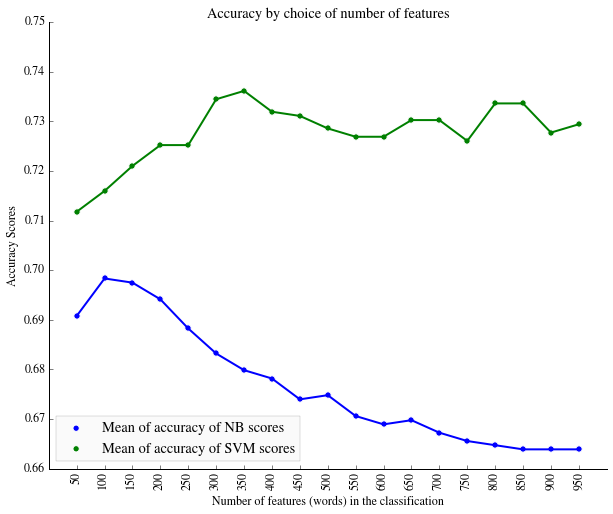

In [62]:
plt.subplots(figsize=(10,8))
scoreNB_means = np.mean(clfNB_scores, axis=1)
plt.plot(runs,scoreNB_means, color='b')
plt.scatter(runs,scoreNB_means, c='b', s=40, label= 'Mean of accuracy of NB scores')

scoreSVM_means = np.mean(clfSVM_scores, axis=1)
plt.plot(runs,scoreSVM_means, color='g')
plt.scatter(runs,scoreSVM_means, c='g', s=40, label= 'Mean of accuracy of SVM scores')

plt.title('Accuracy by choice of number of features')
plt.legend(frameon=False, loc='lower right')
plt.ylabel('Accuracy Scores')
plt.xlim(-1, len(runs))
plt.xlabel('Number of features (words) in the classification')
plt.xticks(runs, Features, rotation=90)
legend = plt.legend(loc=3,frameon=True,framealpha=0.6, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.2)
remove_border()
plt.show

## Repeat the 10-fold Cross Validation for the F1 score

In [26]:
# For the F1 calculation the data labels need to be binarized
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
ydata_train =  np.array([number[0] for number in lb.fit_transform(Ydata_train)])

MAX_FEATURES = 1000
cv = 10

Features = (range(50,MAX_FEATURES, 50))
runs = np.arange(len(Features))
clfNB2_scores = np.zeros((len(Features),cv))
clfSVM2_scores = np.zeros((len(Features),cv))
run = 0
for feat in Features:
    
    clfNB2 = Pipeline(steps=[
    ("vectorizer", HashingVectorizer(tokenizer=word_tokenize_stem, stop_words=all_stopwords_set, lowercase=True, binary=True)),
    ("selector", SelectKBest(chi2, feat)),
    ('NB', BernoulliNB(alpha=1.0, binarize=None))
])
    clfNB2_scores[run,:] = cross_validation.cross_val_score(clfNB2, Xdata_train, ydata_train, cv=cv, scoring = 'f1' , n_jobs = 1)
    
    clfSVM2 = Pipeline(steps=[
    ("vectorizer", HashingVectorizer(tokenizer=word_tokenize_stem, stop_words=all_stopwords_set, lowercase=True, binary=True)),
    ("selector", SelectKBest(chi2, feat)),
    ('SVM', SVC(kernel='rbf', C=600))
])
    clfSVM2_scores[run,:] = cross_validation.cross_val_score(clfSVM2, Xdata_train, ydata_train, cv=cv, scoring = 'f1' , n_jobs = 1)
    run += 1

### And plotting the F1 score by choice of the number of features (words)

<function matplotlib.pyplot.show>

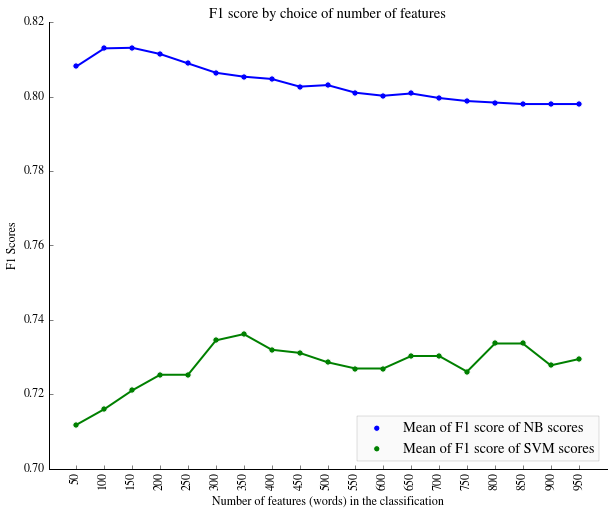

In [60]:
plt.subplots(figsize=(10,8))
scoreNB2_means = np.mean(clfNB2_scores, axis=1)
plt.plot(runs,scoreNB2_means, color='b')
plt.scatter(runs,scoreNB2_means, c='b', s=40, label= 'Mean of F1 score of NB scores')

scoreSVM2_means = np.mean(clfSVM2_scores, axis=1)
plt.plot(runs,scoreSVM_means, color='g')
plt.scatter(runs,scoreSVM_means, c='g', s=40, label= 'Mean of F1 score of SVM scores')

plt.title('F1 score by choice of number of features')
plt.legend(frameon=False, loc='lower right')
plt.ylabel('F1 Scores')
plt.xlim(-1, len(runs))
plt.xlabel('Number of features (words) in the classification')
plt.xticks(runs, Features, rotation=90)
legend = plt.legend(loc=4,frameon=True,framealpha=0.6, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.2)
remove_border()
plt.show

## Classify using both methods Naive Bayes (100 words) and SVM (400 words)

In [28]:
clfNB = Pipeline(steps=[
    ("vectorizer", HashingVectorizer(tokenizer=word_tokenize_stem, stop_words=all_stopwords_set, lowercase=True, binary=True)),
    ("selector", SelectKBest(chi2, 100)),
    ('NB', BernoulliNB(alpha=1.0, binarize=None))
])
    
clfSVM = Pipeline(steps=[
    ("vectorizer", HashingVectorizer(tokenizer=word_tokenize_stem, stop_words=all_stopwords_set, lowercase=True, binary=True)),
    ("selector", SelectKBest(chi2, 400)),
    ('SVM', SVC(kernel='rbf', C=600))
])


In [29]:
# Convenience function to adjust plot parameters for a clear layout.
    
target_names = ["Negative", "Positive"]

def show_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

In [30]:
print ("Total Negative opinion tweets in the test dataset: ", len(Ydata_test[Ydata_test=="Negative"]))
print ("Total Positive opinion tweets in the test dataset: ",len(Ydata_test[Ydata_test=="Positive"]))

Total Negative opinion tweets in the test dataset:  102
Total Positive opinion tweets in the test dataset:  259


## Fitting the models to the test data
We fit from the respective NB and SVM pipelines and generate the predicted labels on the test set

### First for the Naive Bayes classifier

In [31]:
# Fit the Naive Bayes model
clfNB.fit(Xdata_train, ydata_train)
predNB = clfNB.predict(Xdata_test)

### And generate the confusion matrix and the fit statistics

Confusion matrix Naive Bayes 100 Words
    0    1
0  19   83
1   4  255

precision = 0.754, recall = 0.985, F1 = 0.854, accuracy = 0.759

          0         1
0  0.186275  0.320463
1  0.039216  0.984556


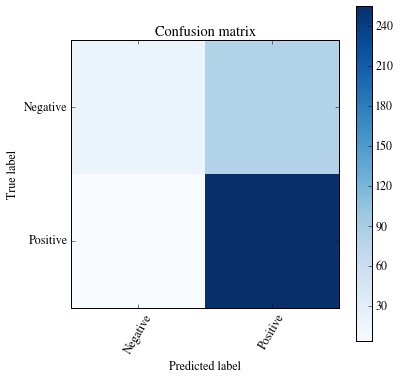

In [59]:
# print results with the confusion matrix and the fit statistics
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
ydata_test =  np.array([number[0] for number in lb.fit_transform(Ydata_test)])

cm_lrNB = confusion_matrix(ydata_test, predNB)
print("Confusion matrix Naive Bayes 100 Words")
print(pd.DataFrame(cm_lrNB))
report_lr = precision_recall_fscore_support(ydata_test, predNB, average='macro')
print("\nprecision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f\n" % (report_lr[0], report_lr[1], report_lr[2], accuracy_score(ydata_test, predNB)))
print(pd.DataFrame(cm_lrNB.astype(np.float64) / cm_lrNB.sum(axis=1)))
    
show_confusion_matrix(cm_lrNB)

In [33]:
clfSVM.fit(Xdata_train, ydata_train)
predSVM = clfSVM.predict(Xdata_test)

### And the same for the SVM classifier

Confusion matrix SVM  400 Words
    0    1
0  51   51
1  21  238

precision = 0.824, recall = 0.919, F1 = 0.869, accuracy = 0.801

          0         1
0  0.500000  0.196911
1  0.205882  0.918919


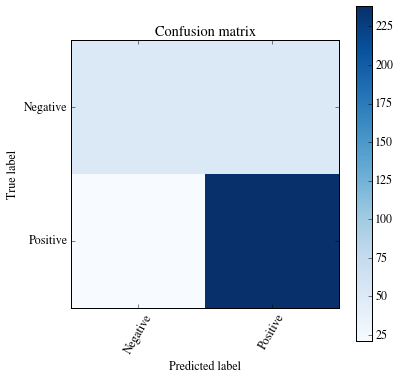

In [58]:
# print results with the confusion matrix and the fit statistics

cm_lrSVM = confusion_matrix(ydata_test, predSVM)
print("Confusion matrix SVM  400 Words")
print(pd.DataFrame(cm_lrSVM))
report_lr = precision_recall_fscore_support(ydata_test, predSVM, average='macro')
print("\nprecision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f\n" % (report_lr[0], report_lr[1], report_lr[2], accuracy_score(ydata_test, predSVM)))
print(pd.DataFrame(cm_lrSVM.astype(np.float64) / cm_lrSVM.sum(axis=1)))
    
show_confusion_matrix(cm_lrSVM)

## Now we make the prediction on the large unlabeled dataset of tweets

In [35]:
Validation['predSVM'] = clfSVM.predict(Validation['Tweets'])
Validation['predNB'] = clfNB.predict(Validation['Tweets'])

In [36]:
byDate = Validation.groupby(['Ident']).mean().reset_index()
byDate['indexNumber'] = [int(i.split('_')[-1]) for i in byDate.Ident]
byDate.sort(['indexNumber'], ascending = [True], inplace = True)
byDate.drop('indexNumber', 1, inplace = True)
byDate =  byDate.reset_index(drop=True) 
#byDate.head(25)

### Generate a plot of the negative "Mood" share for the Twitter data

<function matplotlib.pyplot.show>

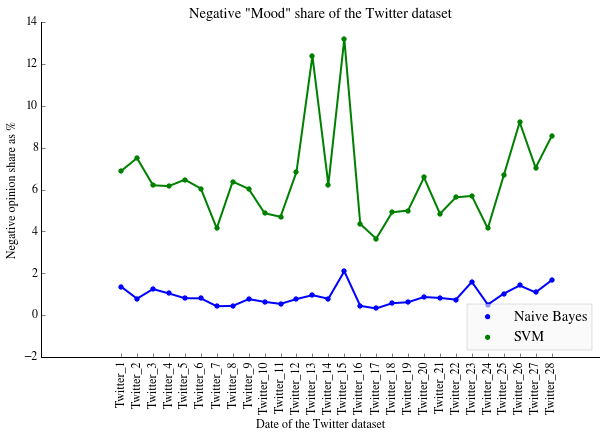

In [55]:
plt.plot(byDate.index,(1-byDate['predNB'])*100, color='b')
plt.scatter(byDate.index,(1-byDate['predNB'])*100, c='b', s=40, label="Naive Bayes")

plt.plot(byDate.index,(1-byDate['predSVM'])*100, color='g')
plt.scatter(byDate.index,(1-byDate['predSVM'])*100, c='g', s=40, label="SVM")

plt.title('Negative "Mood" share of the Twitter dataset')
plt.legend(frameon=False, loc='lower right')
plt.ylabel('Negative opinion share as %')
plt.xlabel('Date of the Twitter dataset')
plt.xticks(byDate.index, byDate['Ident'], rotation=90)
legend = plt.legend(loc=4,frameon=True,framealpha=0.6, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.2)
remove_border()
remove_border()
plt.show

## Next - calculate the rolling window Z-score of the negative Mood (opinion)
This requires use of the pandas "rolling_apply" function, which is really cool in itself


$$ m_z = \frac{m - \bar{x}(\theta [i, \pm k]) }{\sigma(\theta [i, \pm k])} $$

$m$ negative sentiment share at any date   
$\bar{x}(\theta [i, \pm k]) $ mean negative sentiment in the $[i, \pm k]$ window of $m$  
$\sigma(\theta [i, \pm k]) $ standard error of negative sentiment in the $[i, \pm k]$ window of $m$  


In [38]:
# Calculate the rolling Z scores
meanNB = pd.rolling_apply((1-byDate.predNB),7, np.mean, center=True)
stdNB = pd.rolling_apply((1-byDate.predNB),7, np.std, center=True)
byDate['zscoreNB'] = ((1-byDate.predNB)-meanNB)/stdNB

meanSVM = pd.rolling_apply((1-byDate.predSVM),7, np.mean, center=True)
stdSVM = pd.rolling_apply((1-byDate.predSVM),7, np.std, center=True)
byDate['zscoreSVM'] = ((1-byDate.predSVM)-meanSVM)/stdSVM

In [39]:
byDate_zscore = byDate.dropna().reset_index(drop=True)
byDate_zscore.head()

,Ident,predSVM,predNB,zscoreNB,zscoreSVM
0,Twitter_4,0.938308,0.989624,0.381737,-0.040729
1,Twitter_5,0.935238,0.991893,0.059779,0.366893
2,Twitter_6,0.939463,0.991960,0.046649,0.172876
3,Twitter_7,0.958481,0.995718,-1.362159,-1.952286
4,Twitter_8,0.936138,0.995586,-1.241367,1.000567


### and then plot out for both the Naive Bayes and the SVM classifiers

<function matplotlib.pyplot.show>

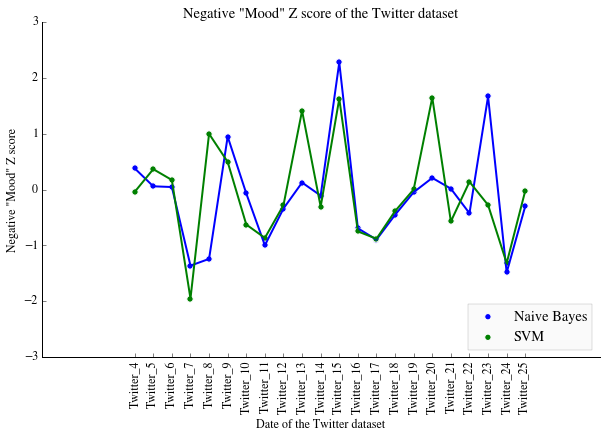

In [54]:
plt.plot(byDate_zscore.index,byDate_zscore.zscoreNB, color='b')
plt.scatter(byDate_zscore.index,byDate_zscore.zscoreNB, c='b', s=40, label="Naive Bayes")

plt.plot(byDate_zscore.index,byDate_zscore.zscoreSVM, color='g')
plt.scatter(byDate_zscore.index,byDate_zscore.zscoreSVM, c='g', s=40, label="SVM")

plt.title('Negative "Mood" Z score of the Twitter dataset')
plt.legend(frameon=False, loc='lower right')
plt.ylabel('Negative "Mood" Z score')
plt.xlabel('Date of the Twitter dataset')
plt.xticks(byDate_zscore.index, byDate_zscore['Ident'], rotation=90)
legend = plt.legend(loc=4,frameon=True,framealpha=0.6, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.2)
remove_border()
remove_border()
plt.show